Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0x22a4cd61
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 200 rows and 200 columns
Presolve time: 0.07s
Presolved: 1250 rows, 5900 columns, 26800 nonzeros
Variable types: 0 continuous, 5900 integer (5900 binary)

Root relaxation: object

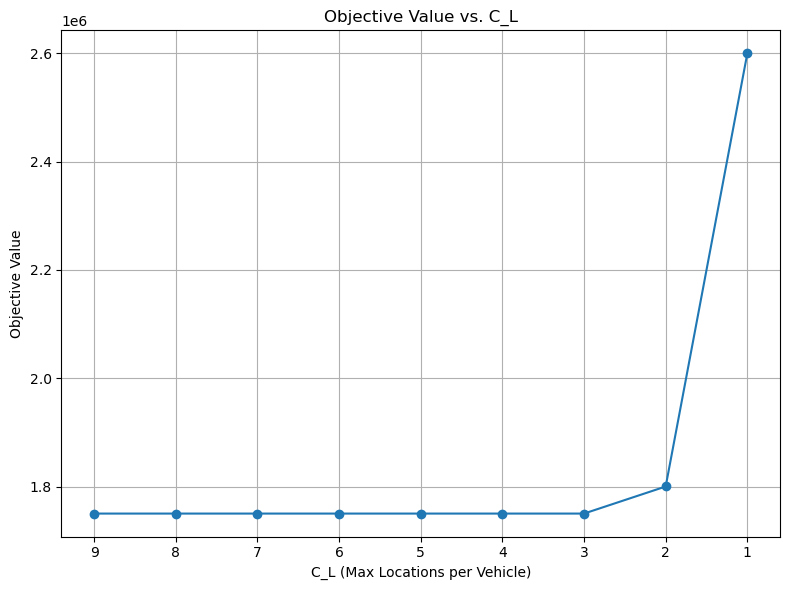

[1750010.925794828, 1750011.0, 1750011.0, 1750011.0, 1750011.0, 1750011.0, 1750011.0, 1800011.0, 2600010.0]


In [4]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(10, 30),
     'volume': random.randint(10, 30),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Turn OFF to keep silent
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect objective value
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)


🟩 Running optimization with C_L = 1

 Optimal Objective Value: 1800009.0
🚚 Vehicles Used: 9

Vehicle 10 (small):
- Tasks: [3, 5]
- Locations: [5]
- Weight Used: 38/100 (38.00%)
- Volume Used: 34/150 (22.67%)

Vehicle 11 (small):
- Tasks: [4, 17, 18]
- Locations: [0]
- Weight Used: 52/100 (52.00%)
- Volume Used: 33/150 (22.00%)

Vehicle 13 (small):
- Tasks: [13, 14, 15]
- Locations: [4]
- Weight Used: 65/100 (65.00%)
- Volume Used: 29/150 (19.33%)

Vehicle 16 (small):
- Tasks: [7]
- Locations: [2]
- Weight Used: 24/100 (24.00%)
- Volume Used: 19/150 (12.67%)

Vehicle 17 (small):
- Tasks: [0, 2, 8]
- Locations: [1]
- Weight Used: 42/100 (42.00%)
- Volume Used: 55/150 (36.67%)

Vehicle 23 (small):
- Tasks: [1, 11]
- Locations: [9]
- Weight Used: 24/100 (24.00%)
- Volume Used: 14/150 (9.33%)

Vehicle 26 (small):
- Tasks: [6, 9, 19]
- Locations: [7]
- Weight Used: 45/100 (45.00%)
- Volume Used: 54/150 (36.00%)

Vehicle 28 (small):
- Tasks: [10, 12]
- Locations: [8]
- Weight Used: 38/100 (3

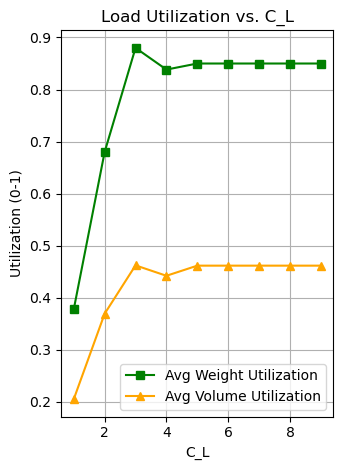

In [14]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Setup
random.seed(1234)
M = 1000
locations = 10
task_count = 20

# Generate Tasks
tasks = [
    {'weight': random.randint(5, 30),
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicles
num_large = 10
num_small = 20
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Store metrics
C_L_values, vehicles_used_list, avg_weight_util_list, avg_volume_util_list = [], [], [], []

# Loop over C_L
for C_L in range(1, 10):
    print("\n" + "=" * 60)
    print(f"🟩 Running optimization with C_L = {C_L}")
    print("=" * 60)

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.start()

        model = gp.Model('VRP', env=env)
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        model.Params.MIPGap = 0.0
        model.optimize()

        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            print(f"\n Optimal Objective Value: {model.ObjVal}")
            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"🚚 Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
            total_weight_util, total_volume_util = 0, 0

            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])
            for r in used_vehicles:
                tasks_r = solution[r]['tasks']
                locs_r = sorted(solution[r]['locations'])
                weight_used = sum(tasks[i]['weight'] for i in tasks_r)
                volume_used = sum(tasks[i]['volume'] for i in tasks_r)
                weight_cap = vehicles[r]['weight_cap']
                volume_cap = vehicles[r]['volume_cap']
                weight_util = weight_used / weight_cap
                volume_util = volume_used / volume_cap
                vehicle_type = "large" if r < num_large else "small"

                print(f"\nVehicle {r} ({vehicle_type}):")
                print(f"- Tasks: {sorted(tasks_r)}")
                print(f"- Locations: {locs_r}")
                print(f"- Weight Used: {weight_used}/{weight_cap} ({weight_util:.2%})")
                print(f"- Volume Used: {volume_used}/{volume_cap} ({volume_util:.2%})")

    
            # for r in used_vehicles:
            #     tasks_r = solution[r]['tasks']
            #     locs_r = sorted(solution[r]['locations'])
            #     weight_used = sum(tasks[i]['weight'] for i in tasks_r)
            #     volume_used = sum(tasks[i]['volume'] for i in tasks_r)
            #     vehicle_type = "large" if r < num_large else "small"
            #     print(f"\nVehicle {r} ({vehicle_type}):")
            #     print(f"- Tasks: {sorted(tasks_r)}")
            #     print(f"- Locations: {locs_r}")
            #     print(f"- Weight Used: {weight_used}/{vehicles[r]['weight_cap']}")
            #     print(f"- Volume Used: {volume_used}/{vehicles[r]['volume_cap']}")

                total_weight_util += weight_used / vehicles[r]['weight_cap']
                total_volume_util += volume_used / vehicles[r]['volume_cap']

            # Location verification
            print(f"\n Location Visit Verification (Max allowed: {C_L}):")
            for r in used_vehicles:
                locs = len(solution[r]['locations'])
                status = "" if locs <= C_L else " VIOLATION"
                vehicle_type = "large" if r < num_large else "small"
                print(f"- Vehicle {r} ({vehicle_type}): {locs} locations {status}")

            # Record averages
            C_L_values.append(C_L)
            vehicles_used_list.append(len(used_vehicles))
            avg_weight_util_list.append(total_weight_util / len(used_vehicles))
            avg_volume_util_list.append(total_volume_util / len(used_vehicles))

        elif model.Status == GRB.INFEASIBLE:
            print(" Model is infeasible!")
            C_L_values.append(C_L)
            vehicles_used_list.append(None)
            avg_weight_util_list.append(None)
            avg_volume_util_list.append(None)
        else:
            print(f" Optimization ended with status: {model.Status}")

# -------------------------------
# Plotting
# -------------------------------


plt.subplot(1, 2, 2)
plt.plot(C_L_values, avg_weight_util_list, marker='s', color='green', label='Avg Weight Utilization')
plt.plot(C_L_values, avg_volume_util_list, marker='^', color='orange', label='Avg Volume Utilization')
plt.title("Load Utilization vs. C_L")
plt.xlabel("C_L")
plt.ylabel("Utilization (0-1)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
import gurobipy as gp
from gurobipy import GRB
import random
# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
C_L = 7   # Max locations per vehicle
locations = 10
task_count = 20

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(5, 30), 
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations-1)}
    for _ in range(task_count)
]

# print("Tasks:", tasks)

# Vehicle Fleet Parameters
num_large = 10
num_small = 20

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())

# print(f"Fleet: {num_large} large + {num_small} small = {len(vehicles)} total vehicles")

# ======================
# Gurobi Model Formulation (Silent Mode)
# ======================
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 0)      # Suppress all output
    env.setParam('LogToConsole', 0)    # Suppress console logging
    env.start()
    
    # Create Gurobi model
    model = gp.Model('VRP_Gurobi', env=env)
    
    # Decision Variables
    t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
    o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
    d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")
    
    # Objective Function
    vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
    location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
    model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)
    
    # Constraints
    for i in range(len(tasks)):
        model.addConstr(
            gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1,
            name=f"task_assignment_{i}"
        )
    
    for r in range(len(vehicles)):
        model.addConstr(
            gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'],
            name=f"weight_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'],
            name=f"volume_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r],
            name=f"location_limit_{r}"
        )
        model.addConstr(
            gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r],
            name=f"vehicle_usage_{r}"
        )
    
    for l in range(locations):
        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r],
                name=f"location_visit_{l}_{r}"
            )
    
    # Only MIPGap, no time limit
    model.Params.MIPGap = 0.0       # optimality gap
    
    # Solve Model
    model.optimize()
    
    # ======================
    # Solution Extraction and Output
    # ======================
    if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
        print(f"\nOptimal Objective Value: {model.ObjVal}")
        used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
        print(f"Vehicles Used: {len(used_vehicles)}")
        solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
        for i in range(len(tasks)):
            for r in used_vehicles:
                if t[i, r].X > 0.5:
                    solution[r]['tasks'].append(i)
                    solution[r]['locations'].add(tasks[i]['loc'])
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            print(f"\nVehicle {r} ({vehicle_type}):")
            print(f"- Tasks: {sorted(solution[r]['tasks'])}")
            print(f"- Locations: {sorted(solution[r]['locations'])}")
            print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
            print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")
        # Location constraint check
        print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            locations_visited = len(solution[r]['locations'])
            status = "" if locations_visited <= C_L else "VIOLATION"
            print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
    elif model.Status == GRB.INFEASIBLE:
        print("Model is infeasible!")
        model.computeIIS()
        model.write("infeasible_model.ilp")
    else:
        print(f"Optimization ended with status: {model.Status}")



Optimal Objective Value: 700009.0
Vehicles Used: 2

Vehicle 3 (large):
- Tasks: [0, 2, 3, 5, 8, 13, 14, 15]
- Locations: [1, 4, 5]
- Weight Used: 145/200
- Volume Used: 118/300

Vehicle 9 (large):
- Tasks: [1, 4, 6, 7, 9, 10, 11, 12, 16, 17, 18, 19]
- Locations: [0, 2, 3, 7, 8, 9]
- Weight Used: 195/200
- Volume Used: 159/300

Location Visit Verification (Max allowed: 7):
- Vehicle 3 (large): 3 locations 
- Vehicle 9 (large): 6 locations 


In [7]:
import gurobipy as gp
from gurobipy import GRB
import random

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 20

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(5, 30),
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 10
num_small = 20

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())

# Iterate over different values of C_L
for C_L in range(1, 10):
    print("\n" + "=" * 50)
    print(f"Running optimization with C_L = {C_L}")
    print("=" * 50)

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('LogToConsole', 0)
        env.start()

        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(
                gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(
                gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(
                    gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        model.Params.MIPGap = 0.0
        model.optimize()

        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            print(f"Objective Value: {model.ObjVal}")
            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])

            print(f"Tightness Report for C_L = {C_L}:")
            for r in used_vehicles:
                weight_used = sum(tasks[i]['weight'] for i in solution[r]['tasks'])
                volume_used = sum(tasks[i]['volume'] for i in solution[r]['tasks'])
                locations_visited = len(solution[r]['locations'])
                print(f"- Vehicle {r}:")
                print(f"  Tasks: {len(solution[r]['tasks'])}, Locations: {locations_visited}, "
                      f"Weight: {weight_used}/{vehicles[r]['weight_cap']}, "
                      f"Volume: {volume_used}/{vehicles[r]['volume_cap']}")
        elif model.Status == GRB.INFEASIBLE:
            print("Model is infeasible!")
        else:
            print(f"Optimization ended with status: {model.Status}")



Running optimization with C_L = 1
Objective Value: 1800009.0
Vehicles Used: 9
Tightness Report for C_L = 1:
- Vehicle 10:
  Tasks: 2, Locations: 1, Weight: 38/100, Volume: 34/150
- Vehicle 11:
  Tasks: 3, Locations: 1, Weight: 52/100, Volume: 33/150
- Vehicle 13:
  Tasks: 3, Locations: 1, Weight: 65/100, Volume: 29/150
- Vehicle 16:
  Tasks: 1, Locations: 1, Weight: 24/100, Volume: 19/150
- Vehicle 17:
  Tasks: 3, Locations: 1, Weight: 42/100, Volume: 55/150
- Vehicle 23:
  Tasks: 2, Locations: 1, Weight: 24/100, Volume: 14/150
- Vehicle 26:
  Tasks: 3, Locations: 1, Weight: 45/100, Volume: 54/150
- Vehicle 28:
  Tasks: 2, Locations: 1, Weight: 38/100, Volume: 14/150
- Vehicle 29:
  Tasks: 1, Locations: 1, Weight: 12/100, Volume: 25/150

Running optimization with C_L = 2
Objective Value: 1000009.0
Vehicles Used: 5
Tightness Report for C_L = 2:
- Vehicle 11:
  Tasks: 5, Locations: 2, Weight: 89/100, Volume: 43/150
- Vehicle 13:
  Tasks: 6, Locations: 2, Weight: 87/100, Volume: 109/150



Running optimization with C_L = 1
Objective Value: 1800009.0
Vehicles Used: 9
Avg Weight Utilization: 0.38
Avg Volume Utilization: 0.21

Running optimization with C_L = 2
Objective Value: 1000009.0
Vehicles Used: 5
Avg Weight Utilization: 0.68
Avg Volume Utilization: 0.37

Running optimization with C_L = 3
Objective Value: 750009.0
Vehicles Used: 3
Avg Weight Utilization: 0.88
Avg Volume Utilization: 0.46

Running optimization with C_L = 4
Objective Value: 750009.0
Vehicles Used: 3
Avg Weight Utilization: 0.84
Avg Volume Utilization: 0.44

Running optimization with C_L = 5
Objective Value: 700009.0
Vehicles Used: 2
Avg Weight Utilization: 0.85
Avg Volume Utilization: 0.46

Running optimization with C_L = 6
Objective Value: 700009.0
Vehicles Used: 2
Avg Weight Utilization: 0.85
Avg Volume Utilization: 0.46

Running optimization with C_L = 7
Objective Value: 700009.0
Vehicles Used: 2
Avg Weight Utilization: 0.85
Avg Volume Utilization: 0.46

Running optimization with C_L = 8
Objective V

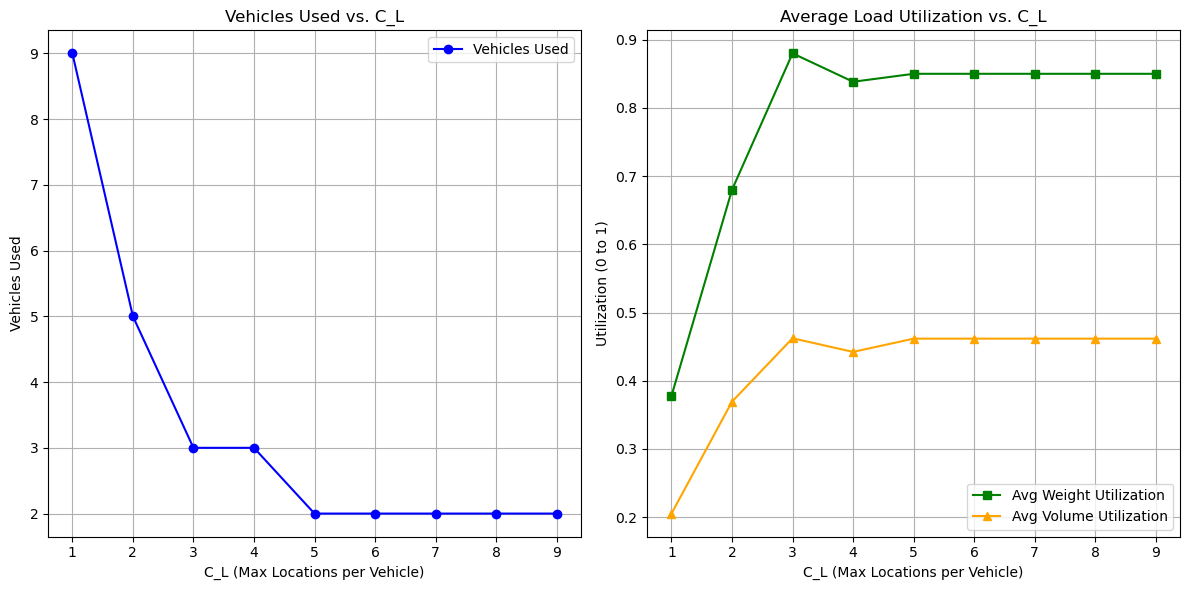

In [8]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 20

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(5, 30),
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 10
num_small = 20

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())

# Store results for plotting
C_L_values = []
vehicles_used_list = []
avg_weight_util_list = []
avg_volume_util_list = []

# Iterate over different values of C_L
for C_L in range(1, 10):
    print("\n" + "=" * 50)
    print(f"Running optimization with C_L = {C_L}")
    print("=" * 50)

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('LogToConsole', 0)
        env.start()

        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(
                gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(
                gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(
                    gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        model.Params.MIPGap = 0.0
        model.optimize()

        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]

            total_weight_util = 0
            total_volume_util = 0

            for r in used_vehicles:
                assigned_tasks = [i for i in range(len(tasks)) if t[i, r].X > 0.5]
                weight_used = sum(tasks[i]['weight'] for i in assigned_tasks)
                volume_used = sum(tasks[i]['volume'] for i in assigned_tasks)

                total_weight_util += weight_used / vehicles[r]['weight_cap']
                total_volume_util += volume_used / vehicles[r]['volume_cap']

            avg_weight_util = total_weight_util / len(used_vehicles)
            avg_volume_util = total_volume_util / len(used_vehicles)

            # Save data for plotting
            C_L_values.append(C_L)
            vehicles_used_list.append(len(used_vehicles))
            avg_weight_util_list.append(avg_weight_util)
            avg_volume_util_list.append(avg_volume_util)

            # Output summary
            print(f"Objective Value: {model.ObjVal}")
            print(f"Vehicles Used: {len(used_vehicles)}")
            print(f"Avg Weight Utilization: {avg_weight_util:.2f}")
            print(f"Avg Volume Utilization: {avg_volume_util:.2f}")

        elif model.Status == GRB.INFEASIBLE:
            print("Model is infeasible!")
            C_L_values.append(C_L)
            vehicles_used_list.append(None)
            avg_weight_util_list.append(None)
            avg_volume_util_list.append(None)
        else:
            print(f"Optimization ended with status: {model.Status}")

# -------------------------------
# Plotting
# -------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot 1: Vehicles Used vs. C_L
plt.subplot(1, 2, 1)
plt.plot(C_L_values, vehicles_used_list, marker='o', color='blue', label='Vehicles Used')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Vehicles Used")
plt.title("Vehicles Used vs. C_L")
plt.grid(True)
plt.legend()

# Plot 2: Utilization vs. C_L
plt.subplot(1, 2, 2)
plt.plot(C_L_values, avg_weight_util_list, marker='s', color='green', label='Avg Weight Utilization')
plt.plot(C_L_values, avg_volume_util_list, marker='^', color='orange', label='Avg Volume Utilization')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Utilization (0 to 1)")
plt.title("Average Load Utilization vs. C_L")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0xd2e861a2
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 50 rows and 0 columns
Presolve time: 0.04s
Presolved: 1400 rows, 6100 columns, 24700 nonzeros
Variable types: 0 continuous, 6100 integer (6100 binary)

Root relaxation: objective

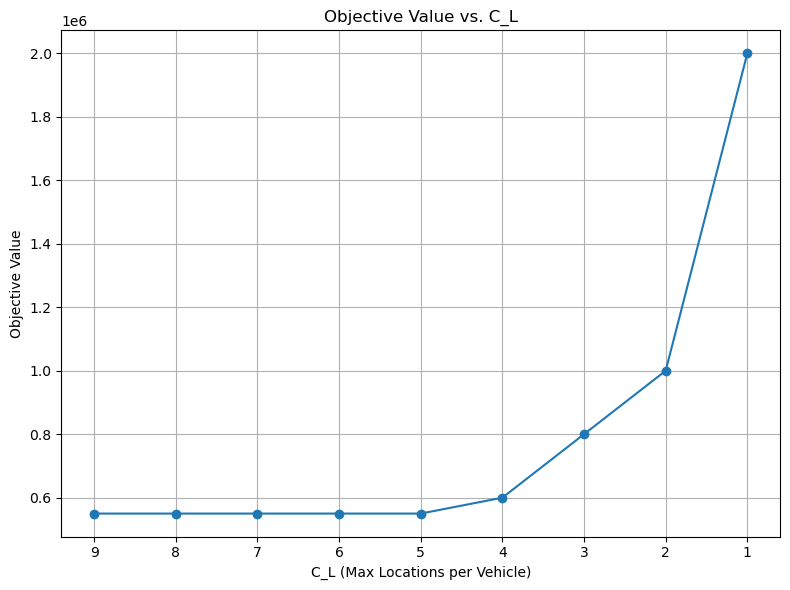

[550010.0, 550010.0, 550010.0, 550010.0, 550010.0, 600010.0, 800010.0, 1000010.0, 2000010.0]


In [9]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(1, 10),
     'volume': random.randint(1, 10),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Turn OFF to keep silent
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect objective value
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
      
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)

Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0x616a32ef
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 150 rows and 0 columns
Presolve time: 0.03s
Presolved: 1300 rows, 6100 columns, 19700 nonzeros
Variable types: 0 continuous, 6100 integer (6100 binary)

Root relaxation: objectiv

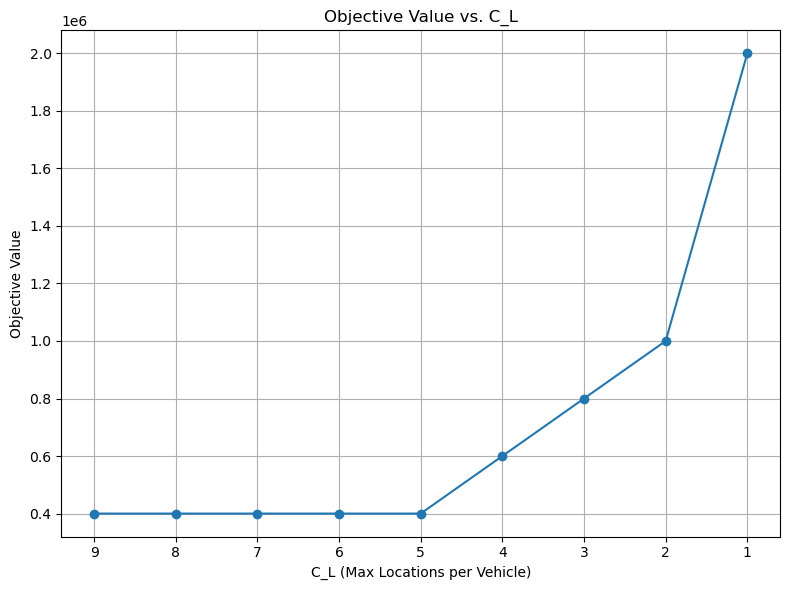

[400010.0, 400010.0, 400010.0, 400010.0, 400010.0, 600010.0, 800010.0, 1000010.0, 2000010.0]


In [10]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(1, 5),
     'volume': random.randint(1, 5),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 400, 'volume_cap': 400, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Turn OFF to keep silent
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect objective value
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)

Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0x609b70b9
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 100 rows and 0 columns
Presolve time: 0.03s
Presolved: 1350 rows, 6100 columns, 22200 nonzeros
Variable types: 0 continuous, 6100 integer (6100 binary)

Root relaxation: objectiv

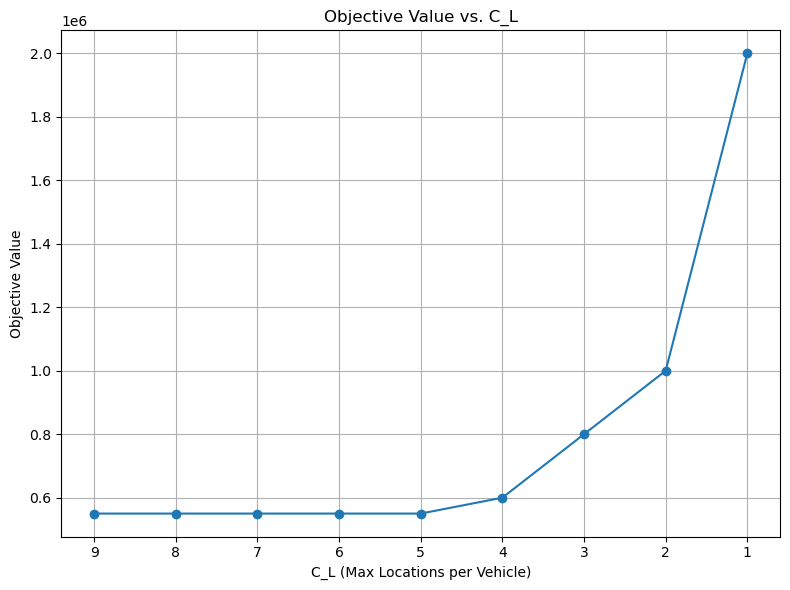

[550010.0, 550010.0, 550010.0, 550010.0, 550010.0, 600010.0, 800010.0, 1000010.0, 2000010.0]


In [11]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(1, 10),
     'volume': random.randint(1, 10),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 400, 'volume_cap': 400, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Set to 0 for silent mode
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect and print solution details
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
            print(f"\n--- C_L = {C_L} ---")
            print(f"Objective Value: {model.ObjVal}")

            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])

            for r in used_vehicles:
                vehicle_type = "large" if r < num_large else "small"
                print(f"\nVehicle {r} ({vehicle_type}):")
                print(f"- Tasks: {sorted(solution[r]['tasks'])}")
                print(f"- Locations: {sorted(solution[r]['locations'])}")
                print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
                print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")

            print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
            for r in used_vehicles:
                vehicle_type = "large" if r < num_large else "small"
                locations_visited = len(solution[r]['locations'])
                status = "" if locations_visited <= C_L else "VIOLATION"
                print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)


Testing for plots


🟩 Running optimization with C_L = 1

✅ Optimal Objective Value: 1800009.0
🚚 Vehicles Used: 9

Vehicle 10 (small):
- Tasks: [3, 5]
- Locations: [5]
- Weight Used: 38/100
- Volume Used: 34/150

Vehicle 11 (small):
- Tasks: [4, 17, 18]
- Locations: [0]
- Weight Used: 52/100
- Volume Used: 33/150

Vehicle 13 (small):
- Tasks: [13, 14, 15]
- Locations: [4]
- Weight Used: 65/100
- Volume Used: 29/150

Vehicle 16 (small):
- Tasks: [7]
- Locations: [2]
- Weight Used: 24/100
- Volume Used: 19/150

Vehicle 17 (small):
- Tasks: [0, 2, 8]
- Locations: [1]
- Weight Used: 42/100
- Volume Used: 55/150

Vehicle 23 (small):
- Tasks: [1, 11]
- Locations: [9]
- Weight Used: 24/100
- Volume Used: 14/150

Vehicle 26 (small):
- Tasks: [6, 9, 19]
- Locations: [7]
- Weight Used: 45/100
- Volume Used: 54/150

Vehicle 28 (small):
- Tasks: [10, 12]
- Locations: [8]
- Weight Used: 38/100
- Volume Used: 14/150

Vehicle 29 (small):
- Tasks: [16]
- Locations: [3]
- Weight Used: 12/100
- Volume Used: 25/150

📍 Locat

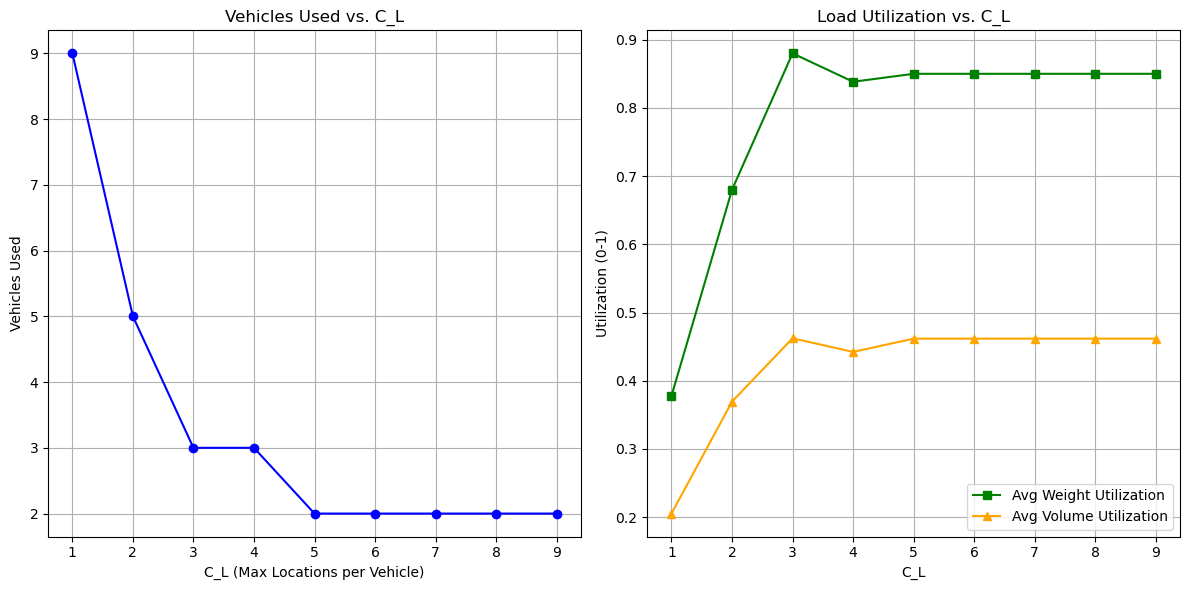

In [15]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Setup
random.seed(1234)
M = 1000
locations = 10
task_count = 20

# Generate Tasks
tasks = [
    {'weight': random.randint(5, 30),
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicles
num_large = 10
num_small = 20
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Store metrics
C_L_values, vehicles_used_list, avg_weight_util_list, avg_volume_util_list = [], [], [], []

# Loop over C_L
for C_L in range(1, 10):
    print("\n" + "=" * 60)
    print(f"🟩 Running optimization with C_L = {C_L}")
    print("=" * 60)

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.start()

        model = gp.Model('VRP', env=env)
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        model.Params.MIPGap = 0.0
        model.optimize()

        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            print(f"\n✅ Optimal Objective Value: {model.ObjVal}")
            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"🚚 Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
            total_weight_util, total_volume_util = 0, 0

            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])

            for r in used_vehicles:
                tasks_r = solution[r]['tasks']
                locs_r = sorted(solution[r]['locations'])
                weight_used = sum(tasks[i]['weight'] for i in tasks_r)
                volume_used = sum(tasks[i]['volume'] for i in tasks_r)
                vehicle_type = "large" if r < num_large else "small"
                print(f"\nVehicle {r} ({vehicle_type}):")
                print(f"- Tasks: {sorted(tasks_r)}")
                print(f"- Locations: {locs_r}")
                print(f"- Weight Used: {weight_used}/{vehicles[r]['weight_cap']}")
                print(f"- Volume Used: {volume_used}/{vehicles[r]['volume_cap']}")

                total_weight_util += weight_used / vehicles[r]['weight_cap']
                total_volume_util += volume_used / vehicles[r]['volume_cap']

            # Location verification
            print(f"\n📍 Location Visit Verification (Max allowed: {C_L}):")
            for r in used_vehicles:
                locs = len(solution[r]['locations'])
                status = "" if locs <= C_L else "❌ VIOLATION"
                vehicle_type = "large" if r < num_large else "small"
                print(f"- Vehicle {r} ({vehicle_type}): {locs} locations {status}")

            # Record averages
            C_L_values.append(C_L)
            vehicles_used_list.append(len(used_vehicles))
            avg_weight_util_list.append(total_weight_util / len(used_vehicles))
            avg_volume_util_list.append(total_volume_util / len(used_vehicles))

        elif model.Status == GRB.INFEASIBLE:
            print("❌ Model is infeasible!")
            C_L_values.append(C_L)
            vehicles_used_list.append(None)
            avg_weight_util_list.append(None)
            avg_volume_util_list.append(None)
        else:
            print(f"⚠️ Optimization ended with status: {model.Status}")

# -------------------------------
# Plotting
# -------------------------------
plt.figure(figsize=(12, 6))

# Plot 1: Vehicles Used
plt.subplot(1, 2, 1)
plt.plot(C_L_values, vehicles_used_list, marker='o', color='blue')
plt.title("Vehicles Used vs. C_L")
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Vehicles Used")
plt.grid(True)

# Plot 2: Utilization
plt.subplot(1, 2, 2)
plt.plot(C_L_values, avg_weight_util_list, marker='s', color='green', label='Avg Weight Utilization')
plt.plot(C_L_values, avg_volume_util_list, marker='^', color='orange', label='Avg Volume Utilization')
plt.title("Load Utilization vs. C_L")
plt.xlabel("C_L")
plt.ylabel("Utilization (0-1)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Trying average utilisation


📦 Iteration for C_L = 1

✅ Optimal Objective Value: 1800009.0
🚚 Vehicles Used: 9

Vehicle 10 (small):
- Tasks: [1, 11]
- Locations: [9]
- Weight Used: 24/100 (24.00%)
- Volume Used: 14/150 (9.33%)

Vehicle 11 (small):
- Tasks: [16]
- Locations: [3]
- Weight Used: 12/100 (12.00%)
- Volume Used: 25/150 (16.67%)

Vehicle 12 (small):
- Tasks: [0, 2, 8]
- Locations: [1]
- Weight Used: 42/100 (42.00%)
- Volume Used: 55/150 (36.67%)

Vehicle 14 (small):
- Tasks: [7]
- Locations: [2]
- Weight Used: 24/100 (24.00%)
- Volume Used: 19/150 (12.67%)

Vehicle 15 (small):
- Tasks: [6, 9, 19]
- Locations: [7]
- Weight Used: 45/100 (45.00%)
- Volume Used: 54/150 (36.00%)

Vehicle 21 (small):
- Tasks: [4, 17, 18]
- Locations: [0]
- Weight Used: 52/100 (52.00%)
- Volume Used: 33/150 (22.00%)

Vehicle 25 (small):
- Tasks: [3, 5]
- Locations: [5]
- Weight Used: 38/100 (38.00%)
- Volume Used: 34/150 (22.67%)

Vehicle 27 (small):
- Tasks: [10, 12]
- Locations: [8]
- Weight Used: 38/100 (38.00%)
- Volume Use

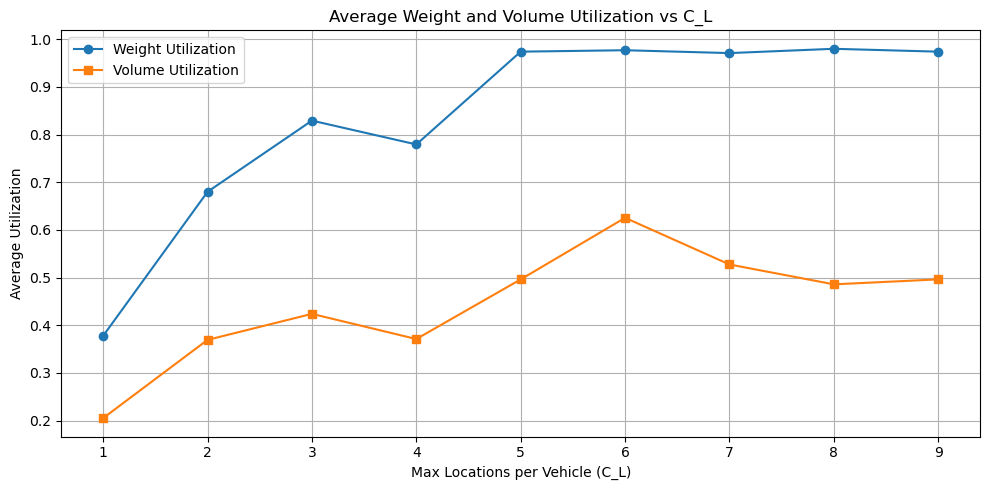

In [16]:
import gurobipy as gp
from gurobipy import GRB
import random

# Set random seed for reproducibility
random.seed(1234)

# Constants
M = 1000
locations = 10
task_count = 20
num_large = 10
num_small = 20

# Generate tasks
tasks = [
    {'weight': random.randint(5, 30),
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations-1)}
    for _ in range(task_count)
]

# Define vehicles
large_vehicle_spec = {'type': 'large', 'weight_cap': 250, 'volume_cap': 400, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + [small_vehicle_spec.copy() for _ in range(num_small)]

# For plotting later (optional)
C_L_values = []
vehicles_used_list = []
avg_weight_util_list = []
avg_volume_util_list = []

# Iterate over C_L from 1 to 9
for C_L in range(1, 10):
    print("\n" + "="*50)
    print(f"📦 Iteration for C_L = {C_L}")
    print("="*50)

    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('LogToConsole', 0)
        env.start()

        model = gp.Model('VRP_Gurobi', env=env)
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        model.Params.MIPGap = 0.0
        model.optimize()

        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            print(f"\n✅ Optimal Objective Value: {model.ObjVal}")
            used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
            print(f"🚚 Vehicles Used: {len(used_vehicles)}")

            solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
            total_weight_util = 0.0
            total_volume_util = 0.0

            for i in range(len(tasks)):
                for r in used_vehicles:
                    if t[i, r].X > 0.5:
                        solution[r]['tasks'].append(i)
                        solution[r]['locations'].add(tasks[i]['loc'])

            for r in used_vehicles:
                tasks_r = solution[r]['tasks']
                locs_r = sorted(solution[r]['locations'])
                weight_used = sum(tasks[i]['weight'] for i in tasks_r)
                volume_used = sum(tasks[i]['volume'] for i in tasks_r)
                weight_cap = vehicles[r]['weight_cap']
                volume_cap = vehicles[r]['volume_cap']
                weight_util = weight_used / weight_cap
                volume_util = volume_used / volume_cap
                vehicle_type = "large" if r < num_large else "small"

                print(f"\nVehicle {r} ({vehicle_type}):")
                print(f"- Tasks: {sorted(tasks_r)}")
                print(f"- Locations: {locs_r}")
                print(f"- Weight Used: {weight_used}/{weight_cap} ({weight_util:.2%})")
                print(f"- Volume Used: {volume_used}/{volume_cap} ({volume_util:.2%})")

                total_weight_util += weight_util
                total_volume_util += volume_util

            print(f"\n📍 Location Visit Verification (Max allowed: {C_L}):")
            for r in used_vehicles:
                locs = len(solution[r]['locations'])
                status = "" if locs <= C_L else "❌ VIOLATION"
                vehicle_type = "large" if r < num_large else "small"
                print(f"- Vehicle {r} ({vehicle_type}): {locs} locations {status}")

            avg_weight_util = total_weight_util / len(used_vehicles)
            avg_volume_util = total_volume_util / len(used_vehicles)
            print(f"\n📊 Average Weight Utilization: {avg_weight_util:.2%}")
            print(f"📊 Average Volume Utilization: {avg_volume_util:.2%}")

            # Save for plotting
            C_L_values.append(C_L)
            vehicles_used_list.append(len(used_vehicles))
            avg_weight_util_list.append(avg_weight_util)
            avg_volume_util_list.append(avg_volume_util)

        elif model.Status == GRB.INFEASIBLE:
            print("❌ Model is infeasible!")
        else:
            print(f"⚠️ Optimization ended with status: {model.Status}")
        import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(C_L_values, avg_weight_util_list, marker='o', label='Weight Utilization')
plt.plot(C_L_values, avg_volume_util_list, marker='s', label='Volume Utilization')
plt.xlabel('Max Locations per Vehicle (C_L)')
plt.ylabel('Average Utilization')
plt.title('Average Weight and Volume Utilization vs C_L')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

